In [1]:
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
import quadpy
from aabbtree import AABB, AABBTree
from polygon_clipping import PolygonClipper
from numba import jit
from plotly import graph_objects as go
import triangle
import meshplot as mp

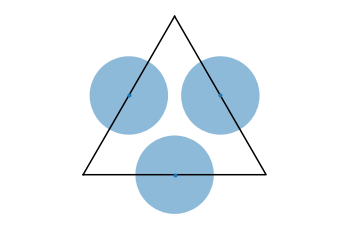

In [2]:
scheme = quadpy.t2.get_good_scheme(2)
scheme.show()
quadrature = list(zip(scheme.weights, scheme.points[:2].T))

In [3]:
def barycentric_coordinates(p, a, b, c):
    """Compute barycentric coordinates (u, v, w) for point p with respect to triangle (a, b, c)"""
    A = np.array([
        [a[0], b[0], c[0]],
        [a[1], b[1], c[1]],
        [1.0, 1.0, 1.0],
    ])
    rhs = np.array([
        [p[0]],
        [p[1]],
        [1.0]
    ])
    uvw = np.linalg.solve(A, rhs)
    assert (np.linalg.norm(A @ uvw - rhs) < 1e-12)
    return uvw

In [4]:
P1_2D_bases = [
    lambda uv: 1 - uv[0] - uv[1], lambda uv: uv[0], lambda uv: uv[1]
]


def P1_2D_gmapping(uv, nodes):
    return sum(phi(uv) * x for phi, x in zip(P1_2D_bases, nodes))


class Element:

    def __init__(self, loc_2_glob, nodes):
        self.nodes = nodes
        self.loc_2_glob = loc_2_glob

    def gmapping(self, uv):
        return P1_2D_gmapping(uv, self.nodes)

    def grad_gmapping(self, uv):
        return 0.5 * np.linalg.norm(
            np.cross(self.nodes[1] - self.nodes[0],
                     self.nodes[2] - self.nodes[0]))

    def inv_gmapping(self, point):
        return barycentric_coordinates(point, *self.nodes)[1:]

    def bases(self):
        return zip(self.loc_2_glob, P1_2D_bases)


class FEMesh:

    def __init__(self, V, F):
        self.elements = []
        for f in F:
            self.elements.append(Element(f, V[f]))
        self.nodes = V.copy()

## Mass Matrix

In [5]:
def build_mass_matrix(mesh):
    M = scipy.sparse.lil_matrix((len(mesh.nodes), len(mesh.nodes)))
    for element in mesh.elements:
        for i, phi_i in element.bases():
            for j, phi_j in element.bases():
                for w, x in quadrature:
                    M[i, j] += w * phi_i(x) * phi_j(x) * \
                        element.grad_gmapping(x)
    return M.tocsc()

## Cross Mass Matrix using Arrangements for Proper Quadrature

In [6]:
def nodes_to_aabb(nodes):
    return AABB(np.vstack([nodes.min(axis=0), nodes.max(axis=0)]).T)


def triangle_fan(convex_polygon):
    assert (len(convex_polygon) >= 3)
    triangles = []
    for i in range(1, len(convex_polygon) - 1):
        triangles.append(
            [convex_polygon[0], convex_polygon[i], convex_polygon[i + 1]])
    return triangles


def triangle_area(vertices):
    return 0.5 * np.linalg.det(np.hstack([vertices, np.ones((3, 1))]))


def build_mass_matrix_cross(mesh_a, mesh_b):
    A = scipy.sparse.lil_matrix((len(mesh_b.nodes), len(mesh_a.nodes)))

    tree = AABBTree()
    for i, element_a in enumerate(mesh_a.elements):
        tree.add(nodes_to_aabb(element_a.nodes), i)

    for element_b in mesh_b.elements:
        assert (triangle_area(element_b.nodes) > 0)
        for element_a_ids in tree.overlap_values(nodes_to_aabb(
                element_b.nodes)):
            element_a = mesh_a.elements[element_a_ids]
            assert (triangle_area(element_a.nodes) > 0)

            clip = PolygonClipper(warn_if_empty=False)
            overlap = clip(element_b.nodes[::-1], element_a.nodes[::-1])[::-1]
            if (len(overlap) < 3):
                continue
            triangles = triangle_fan(overlap)

            for tri in triangles:
                area = triangle_area(tri)
                if abs(area) < 1e-15:
                    continue
                assert (area > 0)
                for w, sub_x_i in quadrature:
                    p = P1_2D_gmapping(sub_x_i, tri)

                    x_i = element_b.inv_gmapping(p)
                    assert(np.linalg.norm(p - element_b.gmapping(x_i)) < 1e-12)

                    x_j = element_a.inv_gmapping(p)
                    assert(np.linalg.norm(p - element_a.gmapping(x_j)) < 1e-12)

                    for i, phi_i in element_b.bases():
                        for j, phi_j in element_a.bases():
                            A[i, j] += w * phi_i(x_i) * phi_j(x_j) * area

    return A.tocsc()

In [7]:
def build_arrangement_mesh(mesh_a, mesh_b):
    V = []
    F = []
    C = []

    i = 0
    c = np.random.random((len(mesh_a.elements) * len(mesh_b.elements), 3))
    for el_i, element_b in enumerate(mesh_b.elements):
        assert (triangle_area(element_b.nodes) > 0)
        # for element_a_ids in tree.overlap_values(nodes_to_aabb(element_b.nodes)):
        for el_j, element_a in enumerate(mesh_a.elements):
            # element_a = mesh_a.elements[element_a_ids]
            # assert(triangle_area(element_a.nodes) > 0)

            clip = PolygonClipper(warn_if_empty=False)
            overlap = clip(element_b.nodes[::-1], element_a.nodes[::-1])[::-1]
            if (len(overlap) < 3):
                continue
            triangles = triangle_fan(overlap)

            for tri in triangles:
                V.extend(tri)
                F.append([len(V) - 3, len(V) - 2, len(V) - 1])
                C.append(c[el_j])

    return (
        np.array(V, dtype=float),
        np.array(F, dtype=int),
        np.array(C, dtype=float))

## $L_2$ Projection

In [8]:
def L2_projection(mesh_a, mesh_b, u):
    """
    Project the quantities in u on to the space spanned by mesh.bases.

    Note: in this context u and u_h are the coefficients.
    """
    M = build_mass_matrix(mesh_b)
    A = build_mass_matrix_cross(mesh_a, mesh_b)
    u_h = scipy.sparse.linalg.spsolve(M, A @ u)  # b = A @ u
    assert (np.linalg.norm(M @ u_h - A @ u) < 1e-12)
    return u_h

## Test: Random Squares

In [9]:
def generate_random_square_triangulation(n=50, allow_steiner=True):
    points = np.vstack([
        [0, 0],
        [1, 0],
        [1, 1],
        [0, 1],
        0.9 * np.random.random((n - 4, 2)) + 0.05,
    ]) - [0.5, 0.5]
    boundary = [
        [0, 1],
        [1, 2],
        [2, 3],
        [3, 0],
    ]
    max_area = 100
    tri = triangle.triangulate({
        "vertices": points,
        "segments": boundary
    }, f'{"" if allow_steiner else "Y"}a{max_area:f}q')
    return tri["vertices"], tri["triangles"]

In [10]:
def plot_mesh(V, F, u=None, **kwargs):
    shading = {
        "flat": True,  # Flat or smooth shading of triangles
        "wireframe": True,
        "wire_width": 0.1,
        "wire_color": "black",  # Wireframe rendering
        "width": 600,
        "height": 600,  # Size of the viewer canvas
        "antialias": True,  # Antialising, might not work on all GPUs
        "scale": 2.0,  # Scaling of the model
        "side":
        "DoubleSide",  # FrontSide, BackSide or DoubleSide rendering of the triangles
        # Colormap and normalization for colors
        "colormap": "viridis",
        "normalize": [None, None],
        "background": "#ffffff",  # Background color of the canvas
        "line_width": 2.0,
        "line_color": "black",  # Line properties of overlay lines
        "bbox": False,  # Enable plotting of bounding box
        "point_color": "red",
        "point_size": 0.05  # Point properties of overlay points
    }
    shading.update(kwargs)
    return mp.plot(V, F, c=u, shading=shading)

In [11]:
np.random.seed(0)
VA, FA = generate_random_square_triangulation(50)
plot_mesh(VA, FA)
VB, FB = generate_random_square_triangulation(100)
plot_mesh(VB, FB)
mesh_a = FEMesh(VA, FA)
mesh_b = FEMesh(VB, FB)
plot_mesh(*build_arrangement_mesh(mesh_a, mesh_b))

/usr/local/lib/python3.10/site-packages/jupyter_client/session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

In [12]:
def compute_error(mesh, u0, u1):
    M = build_mass_matrix(mesh)
    return np.sqrt((u1 - u0).T @ M @ (u1 - u0))

In [13]:
np.random.seed(3)
mesh_a = FEMesh(*generate_random_square_triangulation(50))
mesh_b = FEMesh(*generate_random_square_triangulation(100))
ua_init = np.ones(len(mesh_a.nodes))
ub = L2_projection(mesh_a, mesh_b, ua_init)
ua = L2_projection(mesh_b, mesh_a, ub)
compute_error(mesh_a, ua_init, ua)

2.720471098487214e-14

In [14]:
def perform_n_L2_projections(n, u):
    errors = {"analytical": [], "initial_space": [], "back_one_space": []}

    mesh0 = FEMesh(*generate_random_square_triangulation())
    u0 = np.array([u(*node) for node in mesh0.nodes])

    u_prev = u0
    mesh_prev = mesh0

    for i in range(n):
        mesh = FEMesh(*generate_random_square_triangulation())
        u1 = L2_projection(mesh_prev, mesh, u_prev)
        errors["analytical"].append(
            compute_error(mesh, u1,
                          np.array([u(*node) for node in mesh.nodes])))
        errors["initial_space"].append(
            compute_error(mesh0, u0, L2_projection(mesh, mesh0, u1)))
        errors["back_one_space"].append(
            compute_error(mesh_prev, u_prev,
                          L2_projection(mesh, mesh_prev, u1)))
        mesh_prev = mesh
        u_prev = u1

    return errors

In [15]:
def plot_n_L2_projections_error(errors, u_str):
    fig = go.Figure(data=[
        go.Scatter(x=np.arange(1, 11), y=errors["analytical"],
                   line=dict(width=5), marker=dict(size=10), name="analytical"),
        go.Scatter(x=np.arange(1, 11), y=errors["initial_space"],
                   line=dict(width=5), marker=dict(size=10), name="initial space"),
        go.Scatter(x=np.arange(1, 11), y=errors["back_one_space"],
                   line=dict(width=5), marker=dict(size=10), name="back one space"),
    ])
    
    fig.update_layout(
        title=dict(text=f"L2 Projection Error (u(x,y) = {u_str})", x=0.5),
        width=1200,
        xaxis=dict(ticks="inside"),
        yaxis=dict(ticks="inside", title="error (L2)",
                   exponentformat="power"),
        template="simple_white",
        font=dict(size=18),
        legend=dict(orientation="v", yanchor="top", y=1.15,
                    xanchor="right", x=0.99, bgcolor='rgba(0,0,0,0)', font_size=18),
        margin=dict(l=10, r=10, t=60, b=10))
    
    fig.write_image(f"u={u_str.replace(' ', '')}.png")
    fig.show()

In [16]:
def plot_L2_projection_meshes(u):
    V, F = generate_random_square_triangulation(n=10000)
    u_gt = np.array([u(*node) for node in V])
    plot_mesh(V, F, u_gt, wireframe=False)
    
    np.random.seed(0)
    V0, F0 = generate_random_square_triangulation()
    u0 = np.array([u(*node) for node in V0])
    plot_mesh(V0, F0, u0, wireframe=False)

    V1, F1 = generate_random_square_triangulation()
    u1 = L2_projection(FEMesh(V0, F0), FEMesh(V1, F1), u0)
    print(u1.min(), u1.max())
    plot_mesh(V1, F1, u1, wireframe=False)

    V2, F2 = generate_random_square_triangulation()
    u2 = L2_projection(FEMesh(V1, F1), FEMesh(V2, F2), u1)
    print(u2.min(), u2.max())
    plot_mesh(V2, F2, u2, wireframe=False)

### $u(x, y) = 1$

In [17]:
np.random.seed(0)
uniform_errors = perform_n_L2_projections(10, u=lambda x, y: 1)

In [18]:
plot_n_L2_projections_error(uniform_errors, "1")

In [19]:
plot_L2_projection_meshes(u=lambda x, y: 1)

/usr/local/lib/python3.10/site-packages/jupyter_client/session.py:718: UserWarning:

Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant



Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

0.9999999999999741 1.000000000000061


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

0.9999999999999799 1.000000000000059


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

### $u(x, y) = x + y$

In [20]:
np.random.seed(0)
linear_errors = perform_n_L2_projections(10, u=lambda x, y: x + y)

In [21]:
plot_n_L2_projections_error(linear_errors, "x + y")

In [22]:
plot_L2_projection_meshes(u=lambda x, y: x + y)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

-1.0000000000000013 0.9999999999999998


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

-0.999999999999986 1.0000000000000009


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

### $u(x, y) = x^2 + y^2$

In [23]:
np.random.seed(0)
quadratic_errors = perform_n_L2_projections(10, u=lambda x, y: x**2 + y**2)

In [24]:
plot_n_L2_projections_error(quadratic_errors, "x² + y²")

In [25]:
plot_L2_projection_meshes(u=lambda x, y: x**2 + y**2)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

0.0007725412698326072 0.5004673289516759


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

-0.0017944471367778913 0.5033724814528278


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

### $u(x, y) = \cos(x) + \cos(y)$

In [26]:
np.random.seed(0)
cos_errors = perform_n_L2_projections(10, u=lambda x, y: np.cos(x) + np.cos(y))

In [27]:
plot_n_L2_projections_error(cos_errors, "cos(x) + cos(y)")

In [28]:
plot_L2_projection_meshes(u=lambda x, y: np.cos(x) + np.cos(y))

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

1.754924545098411 1.9995558967294216


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

1.7535077289841043 2.0009018886721046


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

### $u(x, y) = \cos(10x) + \cos(10y)$

In [29]:
np.random.seed(0)
cos10_errors = perform_n_L2_projections(
    10, u=lambda x, y: np.cos(10 * x) + np.cos(10 * y))

In [30]:
plot_n_L2_projections_error(cos10_errors, "cos(10x) + cos(10y)")

In [31]:
plot_L2_projection_meshes(u=lambda x, y: np.cos(10*x) + np.cos(10*y))

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

-1.8061102311639188 2.0121401227842424


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…

-1.8299754133769215 2.090136782475212


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0, 0.0,…